<a href="https://colab.research.google.com/github/NamrataMishra97/Speech-command-recognition/blob/main/EE5600_Namrata_Mishra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reqirements

In [1]:
%pip install kapre==0.1.7
%pip install soundfile

  Created wheel for kapre: filename=kapre-0.1.7-py3-none-any.whl size=11660 sha256=0f6d8d0dbf8145c76a7e7b36c210d09e8abc53ac37d39c67f7bcb6e47deb9ab5
  Stored in directory: /root/.cache/pip/wheels/0e/54/44/78982ae7d93a2ebcf454b3ea87756140fe1357c955cc1b5c4c
Successfully built kapre
  Attempting uninstall: kapre
    Found existing installation: kapre 0.3.5
    Uninstalling kapre-0.3.5:
      Successfully uninstalled kapre-0.3.5


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import kapre
import librosa
import random
import tensorflow as tf
import soundfile as sf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential,Model
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

#Generate Data

In [4]:
data_dir = '/content/drive/MyDrive/speech_project/Dataset/'
os.chdir(data_dir)

data_x = []
data_y = []
for a,i in enumerate(['Back','left','forward','Right','stop']):
    lis = os.listdir(data_dir+i)
    for j in lis:
        l,sr = sf.read(data_dir+i+'/'+j)
        #print(len(l))
        #if(len(l)>=8000):
        data_x.append(l[0:16000])
        data_y.append(a)
        #else:
        #    print(i)
    print(i," Done")

data_x = np.array(data_x)
data_y = np.array(data_y)


np.save('x.npy',data_x)
np.save('y.npy',data_y)

Back  Done
left  Done
forward  Done
Right  Done
stop  Done


#Spilitting data into train and test

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
np_load_old = np.load

np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

data_x = np.load('x.npy')
data_y = np.load('y.npy')
tr_x,te_x, tr_y,te_y = train_test_split(data_x,data_y,stratify=data_y,random_state=123,test_size=0.25)
np.load = np_load_old

In [6]:
x_train = []
y_train = []
for i,j in enumerate(tr_x):
    x= len(j)
    p = 25000-x
    for y in range(1 ,p, 500):
        nx = np.zeros(25000)
        nx[y:y+x] =j
        x_train.append(nx)
        y_train.append(tr_y[i])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i,j in enumerate(te_x):
    x= len(j)
    p = 25000-x
    for y in range(1 ,p, 500):
        nx = np.zeros(25000)
        nx[y:y+x] =j
        x_test.append(nx)
        y_test.append(te_y[i])
x_test = np.array(x_test)
y_test = np.array(y_test)

np.save('x_train.npy',x_train)
np.save('y_train.npy',y_train)
np.save('x_test.npy',x_test)
np.save('y_test.npy',y_test)

#Extract Features

In [7]:
mfcc = Sequential()
mfcc.add(L.Reshape((1, -1)))
mfcc.add(Melspectrogram(padding='same', sr=16000, n_mels=39, n_dft = 1024,
                        power_melgram=2.0, return_decibel_melgram=True,
                        trainable_fb=False, trainable_kernel=False,
                        name='mel_stft'))
mfcc.add(Normalization2D(str_axis='freq'))
mfcc.add(L.Permute((2, 1, 3)))

x_train = mfcc.predict(x_train)
x_train.shape

x_test = mfcc.predict(x_test)
x_test.shape

np.save('mfcc_train.npy',x_train)
np.save('mfcc_test.npy',x_test)

#Loading Dataset

In [8]:
# Change the directory 
data_dir = '/content/drive/MyDrive/speech_project/Dataset/'
os.chdir(data_dir)
x_train = np.load('mfcc_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('mfcc_test.npy')
y_test = np.load('y_test.npy')

#Model

In [9]:
# https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py

os.environ['PYTHONHASHSEED']='123'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

def AttentionModel(sr=16000, iLen=25000):
    
    inputs = L.Input(x_train.shape[1:], name='Input')

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same', name='Conv1')(inputs)
    x = L.BatchNormalization(name='BN1')(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same', name='Conv2')(x)
    x = L.BatchNormalization(name='BN2')(x)

    


    x = L.Reshape(x.shape[1:-1],name='Squeeze')(x)

    n_units = 64
    x = L.LSTM(n_units, return_sequences=True, name='LSTM_Sequences')(x)  

    # Calculate Unit Importance
    xLast = L.Lambda(lambda q: q[:, -1], name='FinalSequence')(x)  # [b_s, vec_dim]
    xLast = L.Dense(xLast.shape[-1], name='UnitImportance')(xLast)

    # Calculate attention
    attScores = L.Dot(axes=[1, 2],name='AttentionScores')([xLast, x])
    attScores = L.Softmax(name='AttentionSoftmax')(attScores)  

    x = L.Dot(axes=[1, 1], name='AttentionVector')([attScores, x])  
    x = L.Dense(32, activation='relu', name='FC')(x)
    outputs = L.Dense(5, activation='softmax', name='Output')(x)
    model = Model(inputs=[inputs], outputs=[outputs], name='Attention')

    return model

model = AttentionModel()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])

In [10]:
model.summary()

Model: "Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 49, 39, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 49, 39, 10)   60          Input[0][0]                      
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 49, 39, 10)   40          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 49, 39, 1)    51          BN1[0][0]                        
__________________________________________________________________________________________

#Train Model

In [11]:
#model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=5,shuffle=True,batch_size=15)
model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=50,shuffle=True,batch_size= 15)

Epoch 1/50
360/360 [==============================] - 20s 50ms/step - loss: 0.3747 - sparse_categorical_accuracy: 0.8694 - val_loss: 0.0174 - val_sparse_categorical_accuracy: 0.9983
Epoch 2/50
360/360 [==============================] - 17s 48ms/step - loss: 0.0023 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0048 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/50
360/360 [==============================] - 17s 48ms/step - loss: 5.7206e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0028 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/50
360/360 [==============================] - 17s 48ms/step - loss: 2.6333e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0017 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/50
360/360 [==============================] - 17s 48ms/step - loss: 1.5809e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0011 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/50
360/360 [==============================] - 17s 48ms/step - loss: 1.

#Check Attention

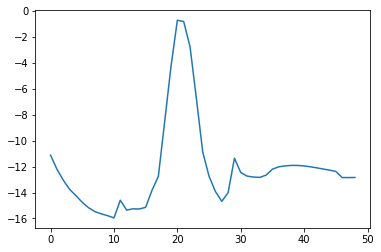

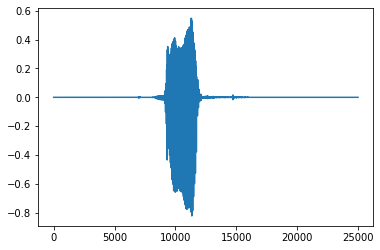

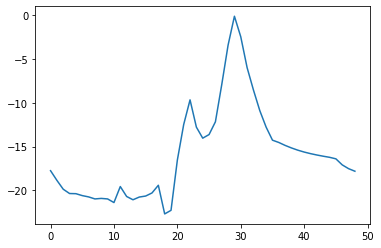

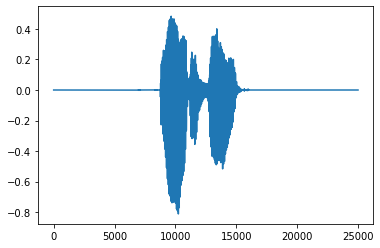

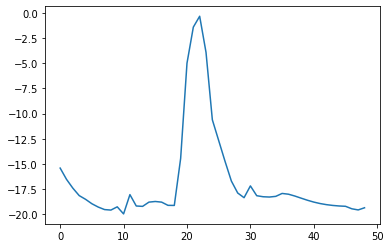

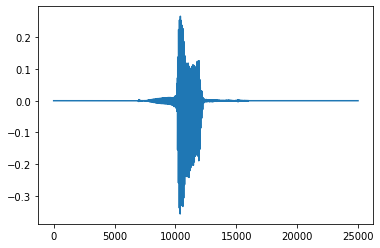

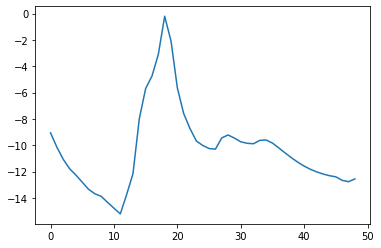

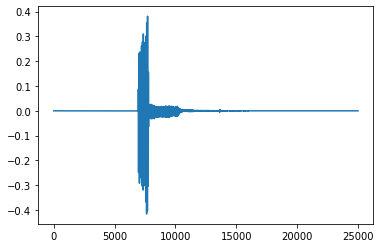

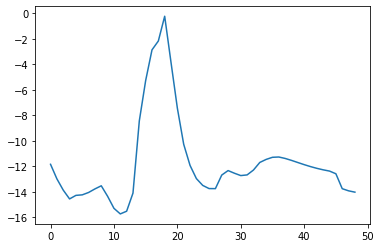

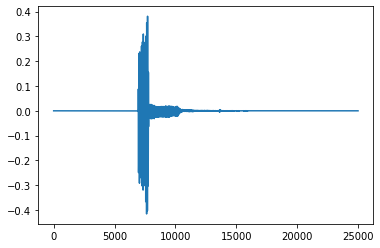

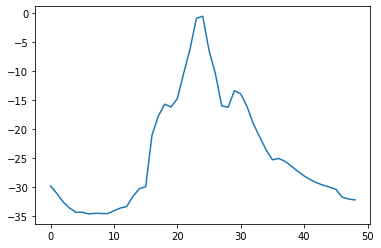

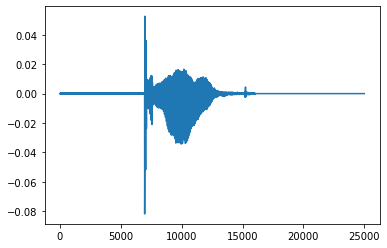

In [12]:
from matplotlib import pyplot as plt
model2 = Model(inputs=model.input, outputs=[model.get_layer('Output').output, 
                                            model.get_layer('AttentionSoftmax').output])
data_dir = '/content/drive/MyDrive/speech_project/Dataset/'
os.chdir(data_dir)
a,b = model2.predict(x_test)
xx_test = np.load('x_test.npy')
for aid in range(0,100,18):
    plt.plot(range(len(b[aid])), np.log(b[aid]))
    plt.show()
    plt.plot(range(len(xx_test[aid])),xx_test[aid])
    plt.show()